In [1]:
import pandas_datareader as reader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [10]:
startdate='2020-01-01'
enddate = '2021-05-18'
df = reader.DataReader('AAPL',data_source='yahoo',start=startdate, end=enddate)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,74.207466
2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.486023
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,74.071579
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.723213
2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,74.909149
...,...,...,...,...,...,...
2021-05-11,126.269997,122.769997,123.500000,125.910004,126142800.0,125.910004
2021-05-12,124.639999,122.250000,123.400002,122.769997,112172300.0,122.769997
2021-05-13,126.150002,124.260002,124.580002,124.970001,105861300.0,124.970001


### Visualize the data

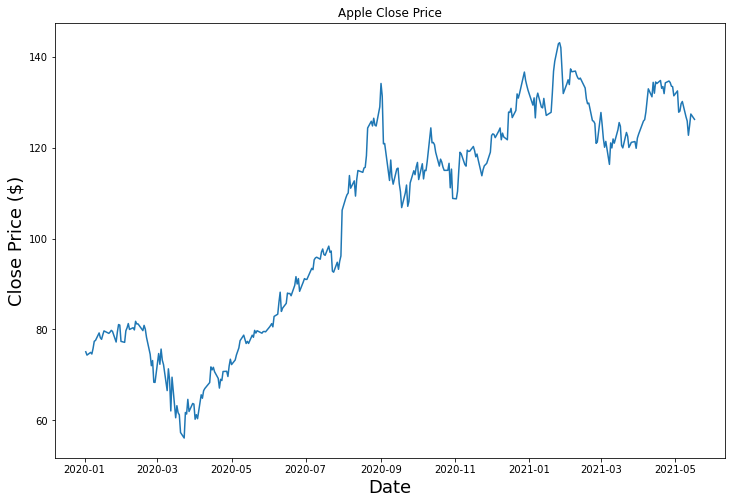

In [11]:
plt.figure(figsize=(12,8))
plt.plot(df['Close'])
plt.title('Apple Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.show()

In [12]:
data_close = df.filter(['Close'])
# returns the numpy array
dataset= data_close.values

train_size = 0.8
train_len = math.ceil(len(dataset)*train_size)
test_len = len(dataset) - train_len
(train_len, test_len)

(277, 69)

### Scalar data


In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
(scaled_data[0], dataset[0])

(array([0.21816409]), array([75.08750153]))

In [20]:
# create train data
train_data = scaled_data[0:train_len,:]
steps = 7
x_train = []
y_train = []

for i in range(steps, len(train_data)):
    x_train.append(train_data[i-steps:i,0])
    y_train.append(train_data[i,0])


In [52]:
x_train[0], y_train[0]
x_train,y_train = np.array(x_train), np.array(y_train)


In [40]:
x.shape, y.shape

((270, 7, 1), (270,))

In [53]:
# LSTM expects input tensor tobe (No Sample, Steps, Features)
x_train = np.reshape(x_train, (x_train.shape[0],steps,1))
x_train.shape

(270, 7, 1)

In [54]:
test_data = scaled_data[train_len-steps:, :]
x_test = []
y_test = dataset[train_len:,:]
for i in range(steps, len(test_data)):
    x_test.append(test_data[i-steps:i,0])
len(x_test), len(y_test)

(69, 69)

In [31]:
x_test = np.array(x_test)

# 3D tesor
x_test = np.reshape(x_test, (x_test.shape[0], steps, 1))
x_test.shape

(69, 7, 1)

In [32]:
# Model Architecture

model =  Sequential()
model.add(LSTM(32,return_sequences=True, input_shape=(steps,1)))
model.add(LSTM(64,return_sequences = True))
model.add(LSTM(128,return_sequences = False))
#FC
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 32)             4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 64)             24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
__________________________________________________

In [34]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [42]:
model.fit(x_train,y_train,batch_size=8, epochs=50)

Epoch 1/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0034
Epoch 2/50
34/34 [==============================] - 1s 18ms/step - loss: 0.0039
Epoch 3/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 4/50
34/34 [==============================] - 1s 18ms/step - loss: 0.0032
Epoch 5/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0029
Epoch 6/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 7/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 8/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0040
Epoch 9/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 10/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 11/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 12/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 13/50
34/34 [==================

In [45]:
# predictions
predictions =  model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# RMSE

rmse = np.sqrt(np.mean(((predictions  - y_test)**2)))
rmse

2.54121007834882

In [48]:
import warnings
warnings.filterwarnings('ignore')

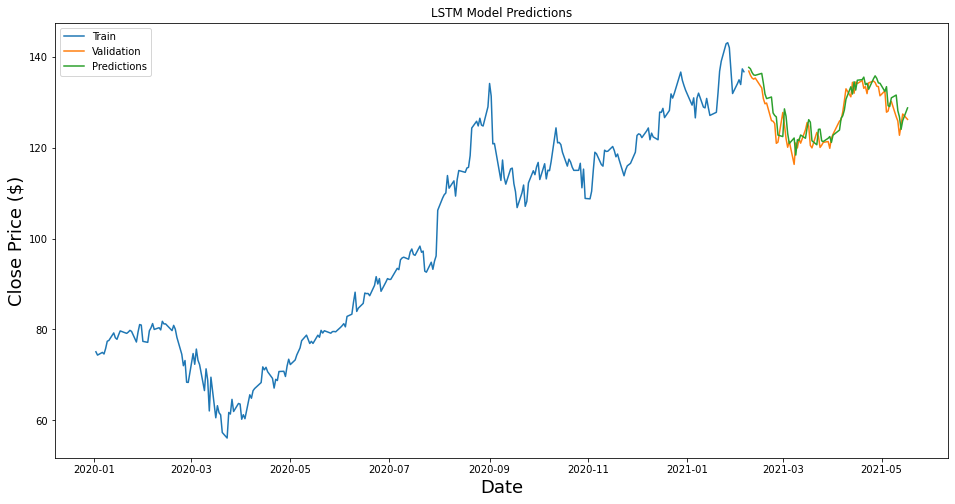

In [50]:
train = data_close[:train_len]
valid = data_close[train_len:]
valid['predictions'] = predictions

plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.title('LSTM Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.legend(['Train','Validation','Predictions'])
plt.show()


In [51]:
valid

,Close,predictions
Date,,
2021-02-08,136.910004,137.731735
2021-02-09,136.009995,137.413666
2021-02-10,135.389999,136.604813
2021-02-11,135.130005,136.068527
2021-02-12,135.369995,135.977676
...,...,...
2021-05-11,125.910004,128.196243
2021-05-12,122.769997,126.823677
2021-05-13,124.970001,124.075241
